# Анализ релуьтатов А/А теста. Проверка корректности работы системы сплитования.

### Шаг 1.  
Сформулируем нулевую и альтернативную гипотезы и зафиксируем уровень значимости:
- H0: CTR_exp_group_2 = CTR_exp_group_3
- H1: CTR_exp_group_2 != CTR_exp_group_3
- alpha = 0.05

### Шаг 2.   
Подключимся к БД, выгрузим в датафрейм пользователей за период проведения А/А теста и рассчитаем ключевую метрику CTR для каждого пользователя.

In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import scipy.stats as stats
import os

In [2]:
# подключаемся к схеме данных ленты новостей
connection = {
    'host': os.environ.get('HOST'),
    'database': os.environ.get('DATABASE'),
    'user': os.environ.get('USER_NAME'),
    'password': os.environ.get('PASSWORD')
}

# Рассчитаем CTR для каждого пользователя и сгруппируем по пользователяю и группе
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2024-04-26' and '2024-05-02'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

ctr_df = ph.read_clickhouse(q, connection=connection)

In [3]:
# Посмотрим, что получилось
ctr_df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,38,248,0.153226
1,3,10326,24,132,0.181818
2,3,123580,25,122,0.204918
3,2,131473,19,98,0.193878
4,2,23985,12,44,0.272727


In [4]:
# Проверим кол-во записей в каждой группе
ctr_df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8362,8362,8362,8362
3,8425,8425,8425,8425


### Шаг 3. 
Проведем симуляцию 10 000 А/А тестов. На каждой итерации сформируем подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Проведем сравнение этих подвыборок t-testом.

In [5]:
# Определяем функцию, которая на вход принимает 2 группы, генерирует подвыборки без повторений и возвращает p-value
def p_values(df1, df2, sample_length):
    sample_2 = df1.sample(sample_length, replace=False)
    sample_3 = df2.sample(sample_length, replace=False)
    return stats.ttest_ind(sample_2, sample_3, equal_var=False)[1]

In [6]:
# Составляем список p-value из 10 000 симуляций
n = 10000
sample_len = 500
pv = [p_values(ctr_df.query("exp_group == 2").ctr, ctr_df.query("exp_group == 3").ctr, sample_len) for _ in range(n)]

### Шаг 4.   
Построим гистограмму распределения получившихся 10000 p-values.

<Axes: ylabel='Count'>

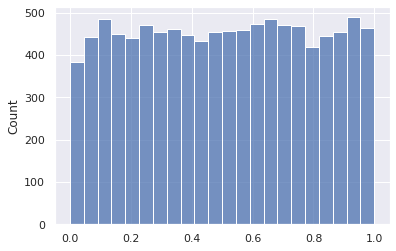

In [8]:
#sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(pv)

### Шаг 5.   
Посчитаем, какой процент p-value оказался меньше или равен уровню альфа = 0.05

In [13]:
pv_percent = list(filter(lambda x: x<=0.05, pv))
print(round(len(pv_percent)/len(pv)*100,2), '%', sep='')

4.27%


### Вывод:
    

Распределение p-values получилось близкое к равномерному.  
Значения p-value <= 0.05 встречается менее, чем в 5% случаев.  
Это значит, что в процессе проведения экспериментов проблем нет.  
Проведенный А/А тест говорит о том, что система сплитования работает корректно.